In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import sys

import matplotlib.pyplot as plt 
import time   

import os
import argparse




### 1.1 Enable GPU

From "Edit -> Notebook Settings -> Hardware accelerator" select GPU. With the following we will specify to PyTorch that we want to use the GPU.

In [11]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


### 2 Model Definition


In the original paper there are two different frameworks; ResNet and VGG. In this section, different models for different frameworks are created. However, in the original paper different normalization methods are applied in these frameworks and as mentioned the authors of the paper propose a new method which is called momentum Batch Normalization. In ResNet and VGG frameworks a naive batch normalization block is used and modified according to the proposed Momentum Batch Normalization method. On the other hand, Pytorch functions are used directly for other normalization methods such as Group Normalization, Layer Normalization, Instance Normalization and Batch Normalization for ResNet. 

### 2.1 Momentum Batch Normalization

In the original paper a novel method is proposed called Momentum Batch Normalization. In this section, naive batch normalization implementation is taken from Dive Into Deep Learning book and it is modified according to the original paper. 



In [12]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, moving_mean_inf, moving_var_inf, momentum, momentum_inf, eps):
    # Use `is_grad_enabled` to determine whether the current mode is training
    # mode or prediction mode
    if not torch.is_grad_enabled():
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean_inf) / torch.sqrt(moving_var_inf + eps)
        Y = gamma * X_hat + beta
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)

        
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
        # In training mode, the updated moving mean and updated moving variance are used for the
        # standardization
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
        Y = gamma * X_hat + beta  # Scale and shift
        moving_mean_inf = momentum_inf * moving_mean_inf + (1.0 - momentum_inf) * mean
        moving_var_inf = momentum_inf * moving_var_inf + (1.0 - momentum_inf) * var 
    return Y, moving_mean.data, moving_var.data, moving_mean_inf.data, moving_var_inf.data

class BatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully-connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims, batch_size):
        super().__init__()
        #num_features=64
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        self.moving_mean_inf = torch.zeros(shape)
        self.moving_var_inf = torch.ones(shape)
        self.batch_size = batch_size
        self.momentum_inf = 0.85**(batch_size/4 / 32)

    def forward(self, x):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != x.device:
            self.moving_mean = self.moving_mean.to(x.device)
            self.moving_var = self.moving_var.to(x.device)
            self.moving_mean_inf = self.moving_mean_inf.to(x.device)
            self.moving_var_inf = self.moving_var_inf.to(x.device)
        # Save the updated `moving_mean` and `moving_var`
        ro = min(self.batch_size / 32 , 1)**(1 / epoch_number)
        momentum = ro**((epoch_number)/(epoch_number - 1)*max((epoch_number - epoch), 0))- ro**epoch_number
        momentum=max(0,momentum)
        #print('Momentum:',momentum)
        Y, self.moving_mean, self.moving_var, self.moving_mean_inf, self.moving_var_inf = batch_norm(
            x, self.gamma, self.beta, self.moving_mean, self.moving_var, 
            self.moving_mean_inf, self.moving_var_inf, momentum, self.momentum_inf,
            eps=1e-5)
        return Y

### 2.2 ResNet

ResNet18, ResNet34 and ResNet50 architectures are defined according to the original paper as folllows.

In [13]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, batch_size, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = BatchNorm(planes, 4, batch_size)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = BatchNorm(planes, 4, batch_size)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(self.expansion*planes, 4, batch_size)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, batch_size, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm(planes, 4, batch_size)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = BatchNorm(planes, 4, batch_size)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = BatchNorm(self.expansion*planes, 4, batch_size)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(self.expansion*planes, 4, batch_size)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, batch_size, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.batch_size = batch_size
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = BatchNorm(64, 4, batch_size)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, self.batch_size, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(batch_size):
    return ResNet(BasicBlock, [2, 2, 2, 2], batch_size)


def ResNet34(batch_size):
    return ResNet(BasicBlock, [3, 4, 6, 3], batch_size)


def ResNet50(batch_size):
    return ResNet(Bottleneck, [3, 4, 6, 3], batch_size)


### 2.3 VGG

VGG11 and VGG16 architectures are defined according to the original paper as folllows.


In [14]:
configuration = {
    'VGG11': [64, 'pool', 128, 'pool', 256, 256, 'pool', 512, 512, 'pool', 512, 512, 'pool'],
    'VGG16': [64, 64, 'pool', 128, 128, 'pool', 256, 256, 256, 'pool', 512, 512, 512, 'pool', 512, 512, 512, 'pool']
}


class VGG(nn.Module):
    def __init__(self, vgg_name,batch_size):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 100)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'pool':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           BatchNorm(x, 4, batch_size),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


## 3 The Dataset

In the original paper authors used CIFAR10 and CIFAR100 datasets. In this section torchvision function is used to load train/test datasets;  

*   There are 50000 training images and 10000 test images for  10 different classes for CIFAR10
*   There are 50000 training images and 10000 test images for 100 different classes for CIFAR100.

In the original paper, authors mentions standard data augmentation and preprocessing techniques are used but any specific parameters were not given in the paper or in the supplementary material of the paper. Therefore, data augmentation and preprocessing techniques are taken from the literature and applied to the datasets. 

In the original paper batch size is set to 8, 16 and 32. It can be changed in this section for different experiments.



In [15]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
])

###################
batch_size=32 #batch size (2 per gpu)
m0=32 #ideal batch size
######################


trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2) # 4 gpu

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


### 4 Define and Train Model
In this section user can choose the model between the ResNet18, ResNet34, ResNet50, VGG11 and VGG16 frameworks. 

### 4.1 Define Loss Function and the Optimizer

Instance is created for the model based on the choice.

In the original paper authors used Stochastic Gradient Descent for the optimization with the momentum 0.9 and weight decay 0.0001 paramaeters set. In the experiments these parameters and optimization method from the paper are preserved.

Since the criterion for the loss function is not specified exactly in the original paper Cross-Entropy Loss method is chosen in the experiments.





In [16]:
sys.argv=['']
del sys


best_acc = 0  # best test accuracy
start_epoch = 1  


# Model
print('==> Building model..')

#net = VGG('VGG11',batch_size)
# net = VGG('VGG16',batch_size)
net = ResNet18(trainloader.batch_size)
# net = ResNet34(trainloader.batch_size)
# net = ResNet50(trainloader.batch_size)

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.1*batch_size/64,
                      momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 180], gamma=0.1)



==> Building model..


### 4.2 Train the Model

In the original paper, authors propose a new method in order to train large datasets with small batch-sizes for insufficient memory resources. Therefore, in the experiments considerably smaller batch sizes are used and it extends the training times. In order to overcome high training times problem GPU usage becomes a necessity and cuda is used in the experiments with Colab Pro.



In [17]:
# Training and Accuracy Calculation
def train(verbose=True):
    
    loss_history=[]
    net.train()
    correct = 0
    total = 0
    #for epoch in range(start_epoch, start_epoch+epoch_number):
    
    
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


        loss_history.append(loss.item()) 

    end = time.time()
    if verbose: print(f'Epoch {epoch} / {epoch_number}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5} , Time : {end - start} seconds')            

    global best_acc
    global test_loss
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)  
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()       


    acc = 100.*correct/total
    historyy.append(acc)

    print('acc:',acc,'best_acc:',best_acc)
    if acc > best_acc:
        print('Saving..' )
        
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        best_acc = acc
        
    print('\n\n') 
    scheduler.step() 
    return loss_history      

In [18]:
epoch_number=200
historyy=[]
losses=[]

for epoch in range(start_epoch, start_epoch+epoch_number):
  loss_history=train()




Epoch 1 / 200: avg. loss of last 5 iterations 1.5970205307006835 , Time : 66.03467345237732 seconds
acc: 39.12 best_acc: 0
Saving..



Epoch 2 / 200: avg. loss of last 5 iterations 0.9433666586875915 , Time : 64.85452008247375 seconds
acc: 58.6 best_acc: 39.12
Saving..



Epoch 3 / 200: avg. loss of last 5 iterations 0.8340570092201233 , Time : 65.82135224342346 seconds
acc: 69.17 best_acc: 58.6
Saving..



Epoch 4 / 200: avg. loss of last 5 iterations 0.6230902194976806 , Time : 65.51446199417114 seconds
acc: 75.78 best_acc: 69.17
Saving..



Epoch 5 / 200: avg. loss of last 5 iterations 0.6156484365463257 , Time : 65.71468329429626 seconds
acc: 79.46 best_acc: 75.78
Saving..



Epoch 6 / 200: avg. loss of last 5 iterations 0.3764741599559784 , Time : 65.38649678230286 seconds
acc: 77.29 best_acc: 79.46



Epoch 7 / 200: avg. loss of last 5 iterations 0.5662323117256165 , Time : 66.35640931129456 seconds
acc: 78.87 best_acc: 79.46



Epoch 8 / 200: avg. loss of last 5 iterations 0.544

### 4.3 The Loss Curve
Loss curve is visualized.

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 4.4 Quantitative Analysis

We can analyze the accuracy of the predictions as follows. 

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))  

Accuracy of the network on the 10000 test images: 95 %


In [21]:
print('saving' ,'acc:',best_acc)

saving acc: 95.16


### 5 Results

Accuracy vs epoch is plotted according to the test results. 

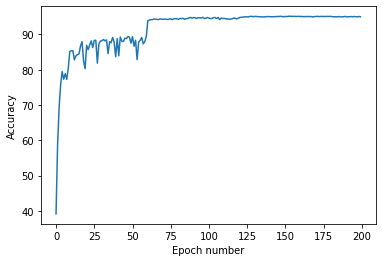

[39.12, 58.6, 69.17, 75.78, 79.46, 77.29, 78.87, 77.25, 80.47, 85.18, 85.41, 85.38, 82.81, 83.93, 84.28, 84.48, 86.74, 87.96, 82.46, 80.3, 86.92, 85.7, 87.03, 88.18, 86.28, 88.33, 88.34, 81.87, 87.3, 88.14, 88.2, 88.57, 88.18, 88.47, 84.56, 87.96, 87.63, 89.17, 87.79, 83.68, 88.82, 83.94, 89.28, 88.09, 87.98, 88.94, 88.79, 89.41, 89.22, 87.52, 89.4, 86.65, 88.35, 82.86, 87.83, 88.31, 89.14, 87.34, 87.93, 89.4, 93.86, 94.07, 94.22, 94.17, 94.39, 94.31, 94.27, 94.21, 94.4, 94.32, 94.29, 94.34, 94.31, 94.23, 94.35, 94.44, 94.19, 94.47, 94.47, 94.43, 94.29, 94.53, 94.48, 94.59, 94.29, 94.48, 94.51, 94.7, 94.82, 94.61, 94.79, 94.74, 94.52, 94.78, 94.7, 94.67, 94.84, 94.5, 94.62, 94.81, 94.64, 94.47, 94.54, 94.78, 94.79, 94.52, 94.81, 94.19, 94.64, 94.5, 94.55, 94.42, 94.41, 94.32, 94.35, 94.4, 94.61, 94.66, 94.41, 94.57, 94.8, 94.84, 94.91, 94.96, 95.01, 94.97, 94.99, 95.14, 95.08, 95.06, 95.11, 95.1, 95.02, 95.05, 94.98, 94.96, 94.97, 95.03, 95.06, 95.06, 95.05, 95.01, 95.02, 95.02, 95.05,

In [22]:
plt.plot(historyy)
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()
print(historyy)